Define constants to be used

In [25]:
import numpy as np

# camera properties
m_camera = 0.002 # mass of camera (kg)
m_wire = 0.008 # mass of camera wire (kg)
d_camera = 3.5 # diameter of camera (mm)

# nitinol tube properties
E_nitinol = 41 # Young's modulus of nitinol (GPa) (ranges from 41-75)
density = 6.5 # density of nitinol (g/cm^3)

# design choices
max_deflection = 0.015 # maximum deflection of tubes at tip
D = 10 # dominating stiffness ratio
clearance = 0.3 # amount of clearance between tubes (mm)
tube_to_camera_ratio = 0.5 # ratio of distal tube diameter to camera diameter (for mounting camera)

Determine tube diameters

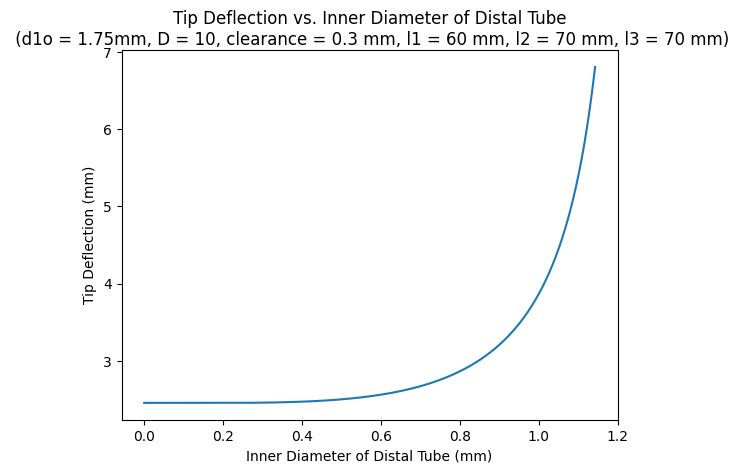

Optimal inner diameter of distal tube: 0.847 mm
Optimal outer diameter of distal tube: 1.270 mm
Inner diameter of middle tube: 1.870 mm
Outer diameter of middle tube: 2.145 mm
Inner diameter of proximal tube: 2.745 mm
Outer diameter of proximal tube: 3.478 mm


In [26]:
import matplotlib.pyplot as plt
import scipy.optimize as opt

def deflection(diameters, lengths, rho, E, m):
    g = 9.81 # gravitational acceleration (m/s^2)
    diameters = diameters * 1e-3
    lengths = lengths * 1e-3
    l1 = lengths[0]
    l2 = lengths[0] + lengths[1]
    l3 = lengths[0] + lengths[1] + lengths[2]
    rho *= 1e3
    E *= 1e9
    
    def moment_of_area(di, do):
        return np.pi/64 * (do**4 - di**4)
    
    def cross_section(di, do):
        return np.pi/4 * (do**2 - di**2)
    
    I = np.zeros(3)
    A = np.zeros(3)
    for i in range(3):
        I[i] = moment_of_area(diameters[2*i], diameters[2*i+1])
        A[i] = cross_section(diameters[2*i], diameters[2*i+1])
    
    term1 = 1/I[0] * (m*l1**3/3 + rho*A[0]*l1**4/8)
    term2 = 1/(I[0]+I[1]) * (m*(l2**3-l1**3)/3 + rho*A[0]*(l2**4-l1**4)/8 + rho*A[1]*((l2**4-l1**4)/8-(l2**3-l1**3)*l1/3+(l2**2-l1**2)*l1**2)/4)
    term3 = 1/(I[0]+I[1]+I[2]) * (m*(l3**3-l2**3)/3 + rho*A[0]*(l3**4-l2**4)/8 + rho*A[1]*((l3**4-l2**4)/8-(l3**3-l2**3)*l1/3+(l3**2-l2**2)*l1**2)/4 + rho*A[2]*((l3**4-l2**4)/8-(l3**3-l2**3)*l2/3+(l3**2-l2**2)*l2**2)/4)
    return g/E * (term1 + term2 + term3)

# pre-determined estimate for the lengths of the tubes
l1 = 50
l2 = 80
l3 = 70

# fix outer diameter of distal tube (random guess at the moment)
# d1o = tube_to_camera_ratio * d_camera # outer diameter of distal tube (mm)?

# specify smallest outer diameter in material selection
d1o = 1.27

test_diameters = np.linspace(0, 0.9*d1o, 1000)
deflections = np.zeros(len(test_diameters))

for i in range(len(test_diameters)):
    d1i = test_diameters[i]
    d2i = d1o + 2*clearance
    d2o = (D*(d1o**4 - d1i**4) + d2i**4)**(1/4)
    d3i = d2o + 2*clearance
    d3o = (D*(d2o**4 - d2i**4) + d3i**4)**(1/4)

    diameters = np.array([d1i, d1o, d2i, d2o, d3i, d3o])
    lengths = np.array([l1, l2, l3])
    m = m_camera + m_wire

    deflections[i] = deflection(diameters, lengths, density, E_nitinol, m)

fig, ax = plt.subplots()
ax.plot(test_diameters, deflections*1000)
ax.set_title('Tip Deflection vs. Inner Diameter of Distal Tube\n (d1o = 1.75mm, D = 10, clearance = 0.3 mm, l1 = 60 mm, l2 = 70 mm, l3 = 70 mm)', wrap=True)
ax.set_xlabel('Inner Diameter of Distal Tube (mm)')
ax.set_ylabel('Tip Deflection (mm)')
plt.show()

# find the optimal inner diameter of the distal tube
def optimize_inner_diameter(d1i, d1o, l1, l2, l3, clearance, D, rho, m, E, tolerance):
    d2i = d1o + 2*clearance
    d2o = (D*(d1o**4 - d1i**4) + d2i**4)**(1/4)
    d3i = d2o + 2*clearance
    d3o = (D*(d2o**4 - d2i**4) + d3i**4)**(1/4)

    res = np.abs(deflection(np.array([d1i, d1o, d2i, d2o, d3i, d3o]), np.array([l1, l2, l3]), rho, E, m)) * 1000 / (l1+l2+l3) - tolerance
    return res
opt_d1i = opt.bisect(optimize_inner_diameter, 0, 0.99*d1o, args=(d1o, l1, l2, l3, clearance, D, density, m_camera+m_wire, E_nitinol, max_deflection))
print('Optimal inner diameter of distal tube: {:.3f} mm'.format(opt_d1i))
print('Optimal outer diameter of distal tube: {:.3f} mm'.format(d1o))
d2i = d1o + 2*clearance
d2o = (D*(d1o**4 - d1i**4) + d2i**4)**(1/4)
d3i = d2o + 2*clearance
d3o = (D*(d2o**4 - d2i**4) + d3i**4)**(1/4)
print('Inner diameter of middle tube: {:.3f} mm'.format(d2i))
print('Outer diameter of middle tube: {:.3f} mm'.format(d2o))
print('Inner diameter of proximal tube: {:.3f} mm'.format(d3i))
print('Outer diameter of proximal tube: {:.3f} mm'.format(d3o))

In [4]:
# manual
d1i = 0.99822
d1o = 1.27
d2i = 2.667
d2o = (D*(d1o**4 - d1i**4) + d2i**4)**(1/4)
d3i = d2o + 2*clearance
d3o = (D*(d2o**4 - d2i**4) + d3i**4)**(1/4)
print('Inner diameter of middle tube: {:.3f} mm'.format(d2i))
print('Outer diameter of middle tube: {:.3f} mm'.format(d2o))
print('Inner diameter of proximal tube: {:.3f} mm'.format(d3i))
print('Outer diameter of proximal tube: {:.3f} mm'.format(d3o))

Inner diameter of middle tube: 2.667 mm
Outer diameter of middle tube: 3.031 mm
Inner diameter of proximal tube: 3.631 mm
Outer diameter of proximal tube: 4.757 mm


In [27]:
# manual
d1i = 0.99822
d1o = 1.27
d2i = 1.49352
d2o = 1.9304
d3i = d2o + 2*clearance
d3o = (D*(d2o**4 - d2i**4) + d3i**4)**(1/4)
print('Inner diameter of middle tube: {:.3f} mm'.format(d2i))
print('Outer diameter of middle tube: {:.3f} mm'.format(d2o))
print('Inner diameter of proximal tube: {:.3f} mm'.format(d3i))
print('Outer diameter of proximal tube: {:.3f} mm'.format(d3o))

Inner diameter of middle tube: 1.494 mm
Outer diameter of middle tube: 1.930 mm
Inner diameter of proximal tube: 2.530 mm
Outer diameter of proximal tube: 3.377 mm


In [35]:
def compute_D(inner_pair, outer_pair):
    return (outer_pair[1]**4 - outer_pair[0]**4) / (inner_pair[1]**4 - inner_pair[0]**4)

def cleance_pairs(inner_pair, outer_pair):
    return (outer_pair[0] - inner_pair[1])/2

pair1 = (0.99822, 1.27)
pair2 = (1.49352, 1.9304)
pair3 = (2.5146, 2.7178)
pair4 = (2.99974, 3.29946)

print('D1: {:.3f}'.format(compute_D(pair1, pair2)))
print('C1: {:.3f}'.format(cleance_pairs(pair1, pair2)))
print('D2: {:.3f}'.format(compute_D(pair2, pair3)))
print('C2: {:.3f}'.format(cleance_pairs(pair2, pair3)))
print('D3: {:.3f}'.format(compute_D(pair2, pair4)))
print('C3: {:.3f}'.format(cleance_pairs(pair2, pair4)))

D1: 5.540
C1: 0.112
D2: 1.636
C2: 0.292
D3: 4.213
C3: 0.535


# Optimizing the lengths and curvatures

Define the testing space

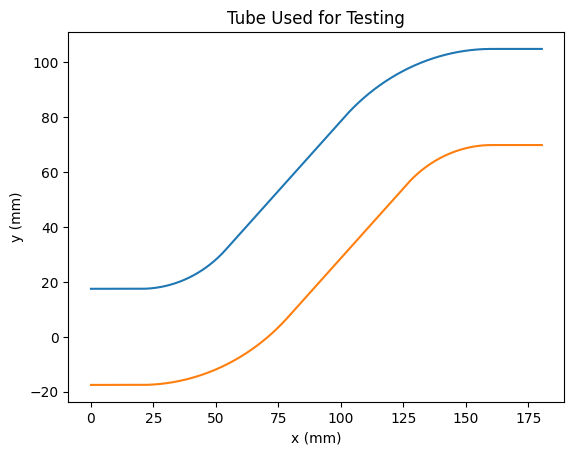

In [54]:
# define the tube used for testing

tube_diameter = 35 # diameter of tube (mm)
tube_radius_of_curvature = 65 # radius of curvature of tube (mm)
tube_curve_length = 51.6 # length of curved section of tube in middle (mm)
middle_length = 68 # length of middle section of tube (mm)
end_lengths = 20 # length of straight sections at ends of tube (mm)

# define the tube used for testing using a numpy array
def create_tube(diameter, radius_of_curvature, curve_length, middle_length, end_lengths):
    theta = curve_length / radius_of_curvature
    x_final = 2*end_lengths + 2*radius_of_curvature*np.sin(theta) + middle_length*np.cos(theta)
    x = np.linspace(0, x_final, 1000)

    r_large = radius_of_curvature + diameter/2
    r_small = radius_of_curvature - diameter/2

    upper_x = [0]
    upper_x.append(end_lengths)
    upper_x.append(end_lengths + r_small*np.sin(theta))
    upper_x.append(end_lengths + r_small*np.sin(theta) + middle_length*np.cos(theta))
    upper_x.append(x_final - end_lengths)
    lower_x = [0]
    lower_x.append(end_lengths)
    lower_x.append(end_lengths + r_large*np.sin(theta))
    lower_x.append(end_lengths + r_large*np.sin(theta) + middle_length*np.cos(theta))
    lower_x.append(x_final - end_lengths)

    conditions = []
    upper = []
    lower = []
    
    upper.append(diameter/2)
    upper.append(lambda x: -np.sqrt(r_small**2 - (x - end_lengths)**2) + radius_of_curvature)
    upper.append(lambda x: np.tan(theta)*(x - upper_x[2]) + r_small*(1-np.cos(theta)) + diameter/2)
    upper.append(lambda x: np.sqrt(r_large**2 - (x - upper_x[4])**2) - radius_of_curvature + 2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta))
    upper.append(2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta) + diameter/2)
    lower.append(-diameter/2)
    lower.append(lambda x: -np.sqrt(r_large**2 - (x - end_lengths)**2) + radius_of_curvature)
    lower.append(lambda x: np.tan(theta)*(x - lower_x[2]) + r_large*(1-np.cos(theta)) - diameter/2)
    lower.append(lambda x: np.sqrt(r_small**2 - (x - lower_x[4])**2) - radius_of_curvature + 2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta))
    lower.append(2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta) - diameter/2)
    
    conditions_list = []
    for changes_x in [upper_x, lower_x]:
        conditions = []
        conditions.append((x <= changes_x[1]))
        conditions.append((x > changes_x[1]) & (x <= changes_x[2]))
        conditions.append((x > changes_x[2]) & (x <= changes_x[3]))
        conditions.append((x > changes_x[3]) & (x <= changes_x[4]))
        conditions.append((x > changes_x[4]))
        conditions_list.append(conditions)
    
    return x, np.piecewise(x, conditions_list[0], upper), np.piecewise(x, conditions_list[1], lower)

# print(create_tube(x_vals, tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths))

# plot the tube used for testing
tube = create_tube(tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths)
fig, ax = plt.subplots()
ax.plot(tube[0], tube[1])
ax.plot(tube[0], tube[2])
ax.set_title('Tube Used for Testing', wrap=True)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.show()
